# Start pyspark #

** Start pyspark notebook using: **

`Adarshs-MacBook-Pro:spark-2.0.1-bin-hadoop2.7 adarshnair$ PYSPARK_DRIVER_PYTHON="/Users/adarshnair/graphlab/anaconda/bin/jupyter-notebook" ./bin/pyspark`


** Start pyspark ipython terminal using: ** 

`Adarshs-MacBook-Pro:spark-2.0.1-bin-hadoop2.7 adarshnair$ PYSPARK_DRIVER_PYTHON="/Users/adarshnair/graphlab/anaconda/bin/ipython" PYSPARK_DRIVER_PYTHON_OPTS="--pylab" ./bin/pyspark`

In [5]:
# Check if SparkContext is running.
print sc.version

2.0.1


In [2]:
# Get Spark configuration
sc._conf.getAll()

[(u'hive.metastore.warehouse.dir',
  u'/Users/adarshnair/spark-2.0.1-bin-hadoop2.7/spark_projects/MovieLens/spark-warehouse'),
 (u'spark.sql.catalogImplementation', u'hive'),
 (u'spark.rdd.compress', u'True'),
 (u'spark.serializer.objectStreamReset', u'100'),
 (u'spark.master', u'local[*]'),
 (u'spark.executor.id', u'driver'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.driver.host', u'10.44.110.244'),
 (u'spark.driver.port', u'58984'),
 (u'spark.app.id', u'local-1476753736275'),
 (u'spark.app.name', u'PySparkShell')]

# Step 0: Loading and exploring the dataset # 


This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies. 
* Each user has rated at least 20 movies. 
* Simple demographic info for the users (age, gender, occupation, zip)


**u.data**      -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The time stamps are unix seconds since 1/1/1970 UTC. 
              The data is randomly ordered. This is a tab separated list of 
	         
             `user id | item id | rating | timestamp. `
               

**u.info**     -- The number of users, items, and ratings in the u data set.

**u.item**     -- Information about the items (movies); this is a tab separated
              list of the following. The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.
              
              `movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |`
              
              
              

**u.genre**    -- A list of the genres.

**u.user**     -- Demographic information about the users; this is a tab
              separated list of the following. The user ids are the ones used in the u.data data set.
              
              `user id | age | gender | occupation | zip code`
              
              
              

**u.occupation** -- A list of the occupations.

More details about the dataset can be viewed here - http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

In [3]:
# Load libraries
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
PATH = "/Users/adarshnair/spark-2.0.1-bin-hadoop2.7/spark_projects/MovieLens"

# Store the u.user data in user_data RDD
user_data = sc.textFile("%s/ml-100k/u.user" % PATH)
user_data.first()

u'1|24|M|technician|85711'

# Step 1.1: User Data preprocessing and Exploration#

Here we will explore the `u.user` dataset.

In [6]:
'''
We will work with the user data to start 
Split the data across the '|' pipe so that each record is a list of:
user id | age | gender | occupation | zip code
'''

user_fields = user_data.map(lambda x: x.split('|'))
user_fields.first()

[u'1', u'24', u'M', u'technician', u'85711']

In [7]:
'''
Counting the number of users, genders, occupations and zipcodes
'''
# number of users
num_users = user_fields.map(lambda x: x[0]).count()
# number of genders
num_genders = user_fields.map(lambda x: x[2]).distinct().count()
# number of occupations
num_occupations = user_fields.map(lambda x: x[3]).distinct().count()
# number of zipcodes 
num_zipcodes = user_fields.map(lambda x: x[4]).distinct().count()

print "Users: %d, genders: %d, occupations: %d, ZIP codes: %d" % \
(num_users, num_genders, num_occupations, num_zipcodes)

Users: 943, genders: 2, occupations: 21, ZIP codes: 795


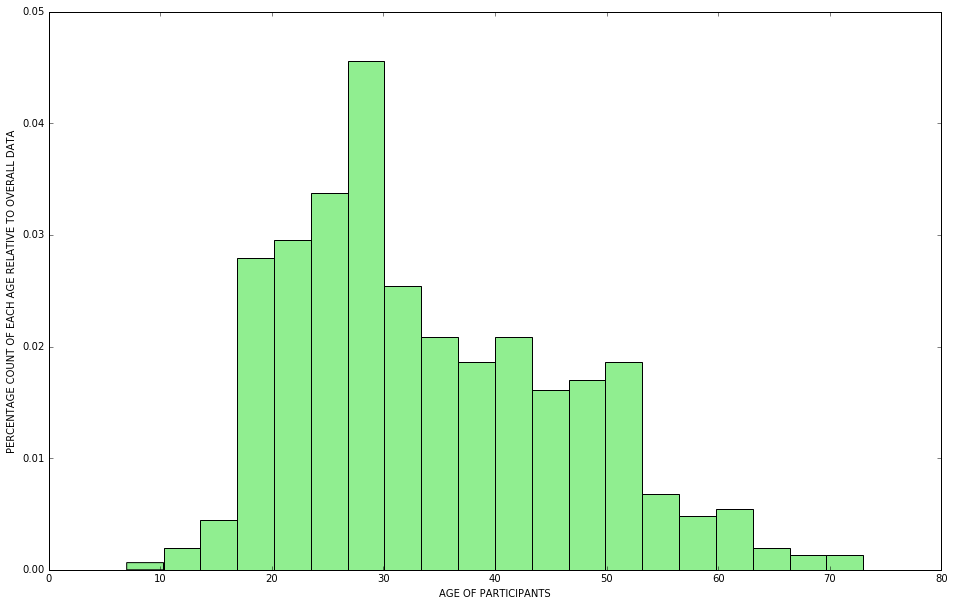

In [44]:
'''
Checking age distribution of users using a histogram.
Set normed = True so that each bucket represents the percentage of the overall data.
'''
ages = user_fields.map(lambda x: int(x[1])).collect()
hist(ages,
    bins = 20,
    color = 'lightgreen',
    normed = True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)
matplotlib.pyplot.xlabel('AGE OF PARTICIPANTS')
matplotlib.pyplot.ylabel('PERCENTAGE COUNT OF EACH AGE RELATIVE TO OVERALL DATA')

In [20]:
'''
Part 1(without using MapReduce):
Checking the distribution of occupations
'''
# Set each row in the RDD to 1 for the occupation in that row, 
# then sum according to that occupation.
count_by_occupation = user_fields.map(lambda x : (x[3],1))\
                                 .reduceByKey(lambda x, y : x + y) \
                                 .collect()
import pprint
print "Count by occupation: \n"
pprint.pprint(count_by_occupation)

Count by occupation: 

[(u'administrator', 79),
 (u'retired', 14),
 (u'lawyer', 12),
 (u'none', 9),
 (u'student', 196),
 (u'technician', 27),
 (u'programmer', 66),
 (u'salesman', 12),
 (u'homemaker', 7),
 (u'executive', 32),
 (u'doctor', 7),
 (u'entertainment', 18),
 (u'marketing', 26),
 (u'writer', 45),
 (u'scientist', 31),
 (u'educator', 95),
 (u'healthcare', 16),
 (u'librarian', 51),
 (u'artist', 28),
 (u'other', 105),
 (u'engineer', 67)]


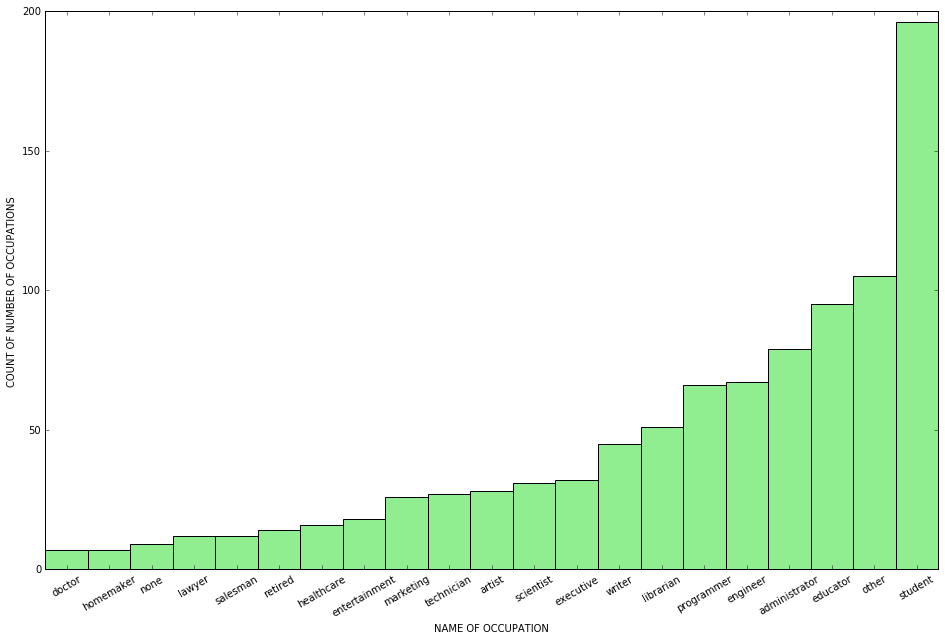

In [46]:
'''
Plotting the distribution of occupations using a bar plot.
'''
# Convert RDD into 2 arrays - x axis(occupations), y axis(count)
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])

# Sort both according to the y axis(counts)
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

# Plotting the data
pos = np.arange(len(x_axis))
width = 1.0

# Aesthetics
ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, 
        y_axis, 
        width, 
        color='lightgreen')

plt.xticks(rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)
matplotlib.pyplot.xlabel('NAME OF OCCUPATION')
matplotlib.pyplot.ylabel('COUNT OF NUMBER OF OCCUPATIONS')

In [31]:
'''
Part 2(using MapReduce):
Checking the distribution of occupations using countByValue

countByValue counts the occurrences of each unique value in the RDD and returns it to the 
driver as a Python dict.
'''
count_by_occupations2 = user_fields.map(lambda x: x[3]).countByValue()
pprint.pprint(dict(count_by_occupations2))

{u'administrator': 79,
 u'artist': 28,
 u'doctor': 7,
 u'educator': 95,
 u'engineer': 67,
 u'entertainment': 18,
 u'executive': 32,
 u'healthcare': 16,
 u'homemaker': 7,
 u'lawyer': 12,
 u'librarian': 51,
 u'marketing': 26,
 u'none': 9,
 u'other': 105,
 u'programmer': 66,
 u'retired': 14,
 u'salesman': 12,
 u'scientist': 31,
 u'student': 196,
 u'technician': 27,
 u'writer': 45}


# Step 1.2 Movie data set  preprocessing and exploration #

Here we will explore the `u.item` dataset.

In [32]:
# Load the dataset
movie_data = sc.textFile("%s/ml-100k/u.item" % PATH)
print movie_data.first()

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0


In [33]:
'''
Data has structure:
movie id | movie title | release date | video release date |
IMDb URL | unknown | Action | Adventure | Animation |
Children's | Comedy | Crime | Documentary | Drama | Fantasy |
Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
Thriller | War | Western |
'''
# Cleaning bad data 
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        # For blank year, return 1900
        return 1900
# Split the data on "|"
movie_fields = movie_data.map(lambda x: x.split('|'))

# Apply cleaning function to all "release date" values in the rows in dataset
years = movie_fields.map(lambda x: x[2]).map(lambda x: convert_year(x))

In [34]:
# Remove rows which have erroneus data, i.e. with release date = 1900
years_filtered = years.filter(lambda x: x != 1900)

In [40]:
'''
Plotting the ages of movies relative to year 1998, which was when the dataset was collected.
'''
movie_ages = years_filtered.map(lambda x: 1998 - x).countByValue()
pprint.pprint(dict(movie_ages))

{0: 65,
 1: 286,
 2: 355,
 3: 219,
 4: 214,
 5: 126,
 6: 37,
 7: 22,
 8: 24,
 9: 15,
 10: 11,
 11: 13,
 12: 15,
 13: 7,
 14: 8,
 15: 5,
 16: 13,
 17: 12,
 18: 8,
 19: 9,
 20: 4,
 21: 4,
 22: 5,
 23: 6,
 24: 8,
 25: 4,
 26: 3,
 27: 7,
 28: 3,
 29: 4,
 30: 6,
 31: 5,
 32: 2,
 33: 5,
 34: 2,
 35: 6,
 36: 5,
 37: 3,
 38: 5,
 39: 4,
 40: 9,
 41: 8,
 42: 4,
 43: 5,
 44: 7,
 45: 2,
 46: 3,
 47: 5,
 48: 7,
 49: 4,
 50: 3,
 51: 5,
 52: 5,
 53: 4,
 54: 5,
 55: 4,
 56: 2,
 57: 5,
 58: 8,
 59: 7,
 60: 3,
 61: 4,
 62: 2,
 63: 4,
 64: 4,
 65: 2,
 66: 1,
 67: 1,
 68: 1,
 72: 1,
 76: 1}


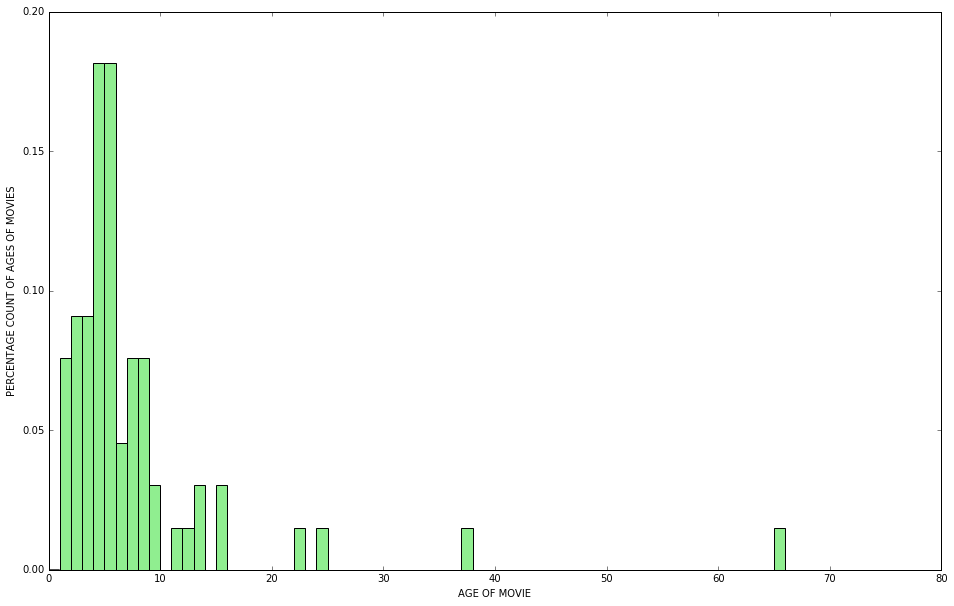

In [47]:
# Plotting the histogram with x axis being the ages, the y axis is count(which is normalized)
hist(movie_ages.values(),
    bins = movie_ages.keys(),
    color = 'lightgreen',
    normed = True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)
matplotlib.pyplot.xlabel('AGE OF MOVIE')
matplotlib.pyplot.ylabel('PERCENTAGE COUNT OF AGES OF MOVIES')

# Step 1.3 Exploring the ratings dataset  #

Here we will be exploring the `u.data` dataset.

In [48]:
'''
Dataset of the form:
user id | item id | rating | timestamp
'''
# Load the dataset
rating_data_raw = sc.textFile("%s/ml-100k/u.data" % PATH)

# Preview the data
print rating_data_raw.first()

196	242	3	881250949


In [49]:
# Get the number of ratings 
num_ratings = rating_data_raw.count()
print "Ratings: %d" % num_ratings

Ratings: 100000


In [103]:
'''
Get the min, max, average and median ratings using reduce()
'''
# Tab separated data
rating_data = rating_data_raw.map(lambda line: line.split("\t"))

# Ratings are in the 3rd column
ratings = rating_data.map(lambda fields: int(fields[2]))

# Max rating
max_rating = ratings.reduce(lambda x, y: max(x, y))

# Min rating
min_rating = ratings.reduce(lambda x, y: min(x, y))

# Mean rating
mean_rating = ratings.reduce(lambda x, y: x + y) / float(num_ratings)

# Median rating
median_rating = np.median(ratings.collect())

ratings_per_user = num_ratings / num_users
num_movies = movie_data.count()
ratings_per_movie = num_ratings / num_movies
print "Min rating: %d" % min_rating
print "Max rating: %d" % max_rating
print "Average rating: %2.2f" % mean_rating
print "Median rating: %d" % median_rating
print "Average # of ratings per user: %2.2f" % ratings_per_user
print "Average # of ratings per movie: %2.2f" % ratings_per_movie

Min rating: 1
Max rating: 5
Average rating: 3.53
Median rating: 4
Average # of ratings per user: 106.00
Average # of ratings per movie: 59.00


In [52]:
'''
Getting stats using stats()
'''
ratings.stats()

(count: 100000, mean: 3.52986, stdev: 1.12566797076, max: 5.0, min: 1.0)

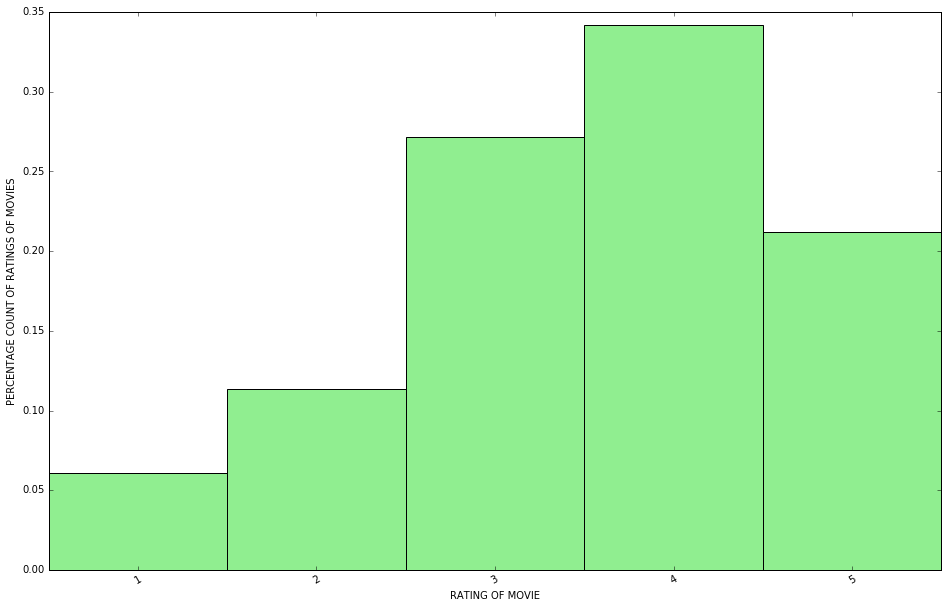

In [53]:
'''
Plot the number of movies for each rating. Normalize the values and draw a bar plot.
'''
count_by_rating = ratings.countByValue()

# Create numpy arrays for x and y axis.
x_axis = np.array(count_by_rating.keys())
y_axis = np.array([float(c) for c in count_by_rating.values()])

# we normalize the y-axis here to percentages
y_axis_normed = y_axis / y_axis.sum()


# Aesthetics
pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, 
        y_axis_normed, 
        width, 
        color='lightgreen')

plt.xticks(rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)
matplotlib.pyplot.xlabel('RATING OF MOVIE')
matplotlib.pyplot.ylabel('PERCENTAGE COUNT OF RATINGS OF MOVIES')

In [54]:
'''
Find the number of ratings given by each user.
'''
# Preview data
# user id | item id | rating | timestamp
print rating_data.first()

[u'196', u'242', u'3', u'881250949']


In [58]:
# Extract user id as KEY and rating as VALUE
user_ratings_grouped = rating_data.map(lambda x: (int(x[0]), int(x[2]))).groupByKey()
user_ratings_grouped.take(5)                       

[(2, <pyspark.resultiterable.ResultIterable at 0x10e4471d0>),
 (4, <pyspark.resultiterable.ResultIterable at 0x10e447090>),
 (6, <pyspark.resultiterable.ResultIterable at 0x10e447f10>),
 (8, <pyspark.resultiterable.ResultIterable at 0x10e447f50>),
 (10, <pyspark.resultiterable.ResultIterable at 0x10e447c50>)]

In [59]:
# For each user id(KEY), find count of rating(VALUE)
user_ratings_by_user = user_ratings_grouped.map(lambda (k,v): (k, len(v)))
user_ratings_by_user.take(5)

[(2, 62), (4, 24), (6, 211), (8, 59), (10, 184)]

[62, 24, 211, 59, 184]


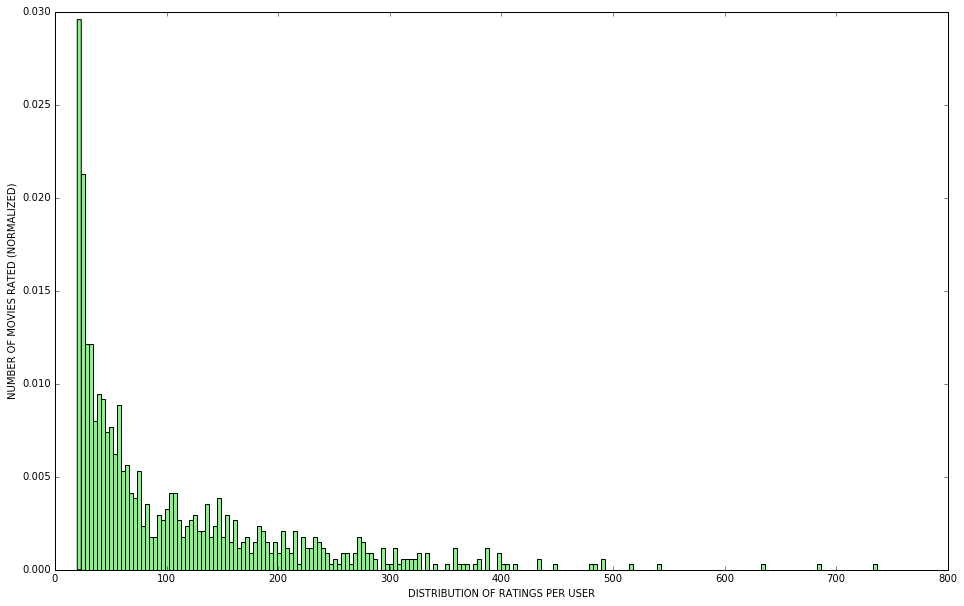

In [67]:
'''
Plot histogram of number of ratings per user
'''
# Get number of movies rated by each user, i.e. just the VALUE's from user_ratings_by_user
user_ratings_by_user_total = user_ratings_by_user.map(lambda (k,v): v).collect()
print user_ratings_by_user_total[:5]

# Plot histogram
hist(user_ratings_by_user_total,
    bins = 200,
    color = 'lightgreen',
    normed = True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)
matplotlib.pyplot.xlabel('DISTRIBUTION OF RATINGS PER USER')
matplotlib.pyplot.ylabel('NUMBER OF MOVIES RATED (NORMALIZED)')

# Step 1.4: Filling in bad or missing values # 

There is 1 bad datapoint in the dataset which we have assigned a release date value of 1900.

We will find that datapoint and replace it with the median release year of the entire dataset.

In [81]:
# Fill in the missing datapoint value with 1900, then collect all rows but that row.
years_pre_processed = movie_fields.map(lambda x: x[2]) \
                                  .map(lambda x: convert_year(x)) \
                                  .filter(lambda x: x != 1900) \
                                  .collect()

In [82]:
# Convert to numpy array
years_pre_processed_arr = np.array(years_pre_processed)  

In [84]:
# Find mean of all rows except where year = 1900
mean_year = np.mean(years_pre_processed_arr[years_pre_processed_arr != 1900])

# Find median of all rows except where year = 1900
median_year = np.median(years_pre_processed_arr[years_pre_processed_arr != 1900])

# Find index of bad data point where year = 1900
# idx_bad_data = np.where(years_pre_processed_arr == 1900)[0][0]

# years_pre_processed_arr[idx_bad_data] = median_year

print "Mean year of release: %d" % mean_year
print "Median year of release: %d" % median_year
print "Index of '1900' after assigning median: %s" % np.where(years_pre_processed_arr == 1900)[0]

Mean year of release: 1989
Median year of release: 1995
Index of '1900' after assigning median: []


# Step 2: Feature Extraction # 

# Step 2.1: Categorical features: 1-of-k encoding of user occupation #

Categorical features can be either nominal(where the values have no particular order) or ordinal(for example a rating from 1 to 5 where 5 is the best rating).

The 1-of-k method is as follows: 

* Assume there are k possible values that a variable can take. 
* We assign each possible value, an index from the set 1 to k.
* In this way we can represent a given state of the variable using a binary vector of length k.
* All entries are zero, except the entry at the index that corresponds to the given state of the variable.

In [88]:
'''
We will use the user_fields RDD:
user id | age | gender | occupation | zip code
'''
# Get all possible occupations
all_occupations = user_fields.map(lambda x: x[3]).distinct().collect()

# Sort the occupations
all_occupations.sort()

In [89]:
'''
1-of-k encoding step.
'''
# Create a new dictionary to hold the occupations, and assign the "1-of-k" indexes
idx = 0
all_occupations_dict = {}

for i in all_occupations:
    all_occupations_dict[i] = idx
    idx +=1

In [90]:
# Checking what "1-of-k" encoding is assigned
print "Encoding of 'doctor': %d" % all_occupations_dict['doctor']
print "Encoding of 'programmer': %d" % all_occupations_dict['programmer']

Encoding of 'doctor': 2
Encoding of 'programmer': 14


In [92]:
'''
Encode the value of programmer.

- Create a numpy array of length that is equal to the possible number of occupations.
- Fill the array with 0s
- Extract the index of 'programmer' and assign a value of 1 to the array value at this index.
'''

# Total possible number of occupations
K = len(all_occupations_dict)

# Numpy array with 0s
binary_x = np.zeros(K)

# Extracting the index of programmer
k_programmer = all_occupations_dict['programmer']
k_programmer

14

In [93]:
# Setting value in numpy array at index 14 to 1.
binary_x[k_programmer] = 1
print "Binary feature vector: %s" % binary_x
print "Length of binary vector: %d" % K

Binary feature vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.]
Length of binary vector: 21


# Step 2.2 Derived Features #

## Step 2.2.a: Transforming timestamps so categorical features ##

In [104]:
'''
Function to extract the timestamps (in seconds) from the dataset
'''
import datetime
def extract_datetime(ts):   
    return datetime.datetime.fromtimestamp(ts)

In [105]:
'''
We will extract the timestamp of when the users gave a rating and in turn extract the hour 
of the day. The result should be an RDD of the hour of the day for each rating.

Rating dataset of the form:
user id | item id | rating | timestamp
'''
# Get timestamp from ratings data
timestamps = rating_data.map(lambda x: int(x[3]))

# Get the hour from timestamps
hour_of_day = timestamps.map(lambda x: extract_datetime(x).hour)

# Preview
hour_of_day.take(10)

[7, 11, 23, 21, 21, 6, 9, 10, 1, 13]

In [106]:
'''
Converting hour data to time-of-day bucket.

'morning' : range(7, 12),
'lunch' : range(12, 14),
'afternoon' : range(14, 18),
'evening' : range(18, 23),
'night' : range(23, 7)
'''
def assign_tod(hr):
    times_of_day = {
                'morning' : range(7, 12), # 7,8,9,10,11
                'lunch' : range(12, 14), # 12, 13
                'afternoon' : range(14, 18), # 14,15,16,17
                'evening' : range(18, 23),
                'night' : range(23, 7)
                }
    for k, v in times_of_day.iteritems():
        # If hr is in the 'value' of the dict, return the 'key'
        if hr in v: 
            return k

In [108]:
# Apply the time-of-day function to the dataset
time_of_day = hour_of_day.map(lambda x: assign_tod(x))
time_of_day.take(2)

['morning', 'morning']

# Step 2.3: Text features # 

In [109]:
'''
Function to strip the year of release for each movie, leaving behind just the title.
'''
import re
def extract_title(raw):    
    # Find the numbers(release year) between parentheses
    grps = re.search("\((\w+)\)", raw)    
    if grps:
        # Strip the trailing whitespace from the title
        return raw[:grps.start()].strip() 
    else:
        return raw

In [110]:
'''
We will be using the Movie dataset of the form:

movie id | movie title | release date | video release date |
IMDb URL | unknown | Action | Adventure | Animation |
Children's | Comedy | Crime | Documentary | Drama | Fantasy |
Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
Thriller | War | Western |
'''
# Get titles
raw_titles = movie_fields.map(lambda x: x[1])

# Test function on five rows
for raw_title in raw_titles.take(5):
    print extract_title(raw_title)

Toy Story
GoldenEye
Four Rooms
Get Shorty
Copycat


In [111]:
# Apply function to all rows
movie_titles = raw_titles.map(lambda x: extract_title(x))

In [113]:
# Tokenize the titles
title_terms = movie_titles.map(lambda x: x.split(' '))

# Preview the tokenized movie titles
print title_terms.take(5)

[[u'Toy', u'Story'], [u'GoldenEye'], [u'Four', u'Rooms'], [u'Get', u'Shorty'], [u'Copycat']]


In [116]:
'''
Building the term dictionary/bag-of-words.

- Use flatmap() to expand the list of strings in each record of the `title_terms` RDD to a new 
RDD of strings where each record is a term called all_terms
- 
'''
all_terms = title_terms.flatMap(lambda x: x).distinct().collect()
# Each record is a unique term from all the titles
all_terms

[u'Mercury',
 u'Duoluo',
 u'Home:',
 u'Quest,',
 u'Seventh',
 u'Noon',
 u'Senseless',
 u"Cuckoo's",
 u'Deconstructing',
 u'Pagemaster,',
 u'Timecop',
 u'Saint',
 u'Tank',
 u'Cyrano',
 u'Color',
 u'Chef',
 u'Entertaining',
 u"Michele's",
 u'Outfield',
 u'Courtyard',
 u'Godfather,',
 u'Morphin',
 u'(Pret-A-Porter)',
 u'Ballroom',
 u'Bites',
 u'qui',
 u'Evil',
 u'Confidential',
 u'Payne',
 u'(Caf\ufffd',
 u'aus',
 u'Foot',
 u'Godfather:',
 u'Generations',
 u'Metro',
 u'Deceit',
 u'4:',
 u'Present',
 u'Mystery',
 u'Darkness,',
 u'Anything',
 u'Hall:',
 u'Industry',
 u"Smilla's",
 u'September',
 u'Mrs.',
 u'Doors',
 u'Still,',
 u'Frankenstein',
 u'(Chao',
 u'Tango',
 u'Ende',
 u'Old',
 u'Coldblooded',
 u'Arabia',
 u'Jersey',
 u'Hunchback',
 u'Contempt',
 u'Murder,',
 u'Tap',
 u'Swept',
 u'Just',
 u'Bedknobs',
 u'Ruby',
 u'Make',
 u'Land,',
 u'Bacon',
 u'Poetic',
 u'Related',
 u'Yue)',
 u'Slickers',
 u'Crude',
 u'Associate,',
 u'Kill',
 u'Desperate',
 u'Go',
 u'Psycho',
 u'Here',
 u'Love!',


In [118]:
'''
Create bag-of-words dictionary where the key is the term and the value is the index of that 
word.

This follows the same methodology as 1-of-k encoding.
'''
idx = 0
all_terms_dict = {}
for term in all_terms:
    all_terms_dict[term] = idx
    idx +=1
pprint.pprint(all_terms_dict)

{u'&': 1494,
 u"'Til": 189,
 u'(A': 2512,
 u'(Ai': 1723,
 u'(Andy': 1428,
 u'(Apur': 1373,
 u'(Azucar': 2404,
 u'(Bewegte': 1858,
 u'(Bis': 1284,
 u'(Blaue': 2073,
 u'(Blechtrommel,': 1039,
 u'(Bulletproof': 712,
 u'(Caf\ufffd': 29,
 u'(Chacun': 1731,
 u'(Chao': 49,
 u'(Cold': 1510,
 u'(Como': 2231,
 u'(Convento,': 833,
 u'(Coup': 229,
 u'(Cristo': 1534,
 u'(De': 475,
 u'(Dear': 1873,
 u'(Dellamorte': 527,
 u'(Double': 591,
 u'(En': 1255,
 u'(Feng': 2086,
 u'(Flor': 711,
 u'(For': 1680,
 u'(Fresa': 2623,
 u'(Gazon': 1810,
 u'(Giardino': 382,
 u"(God's": 573,
 u'(Grand': 944,
 u'(Haine,': 742,
 u'(Her': 2035,
 u'(Hussard': 776,
 u"(J'ai": 613,
 u'(Journey': 764,
 u'(Kavkazsky': 2237,
 u'(Keiner': 2474,
 u'(Killer,': 2232,
 u'(Kokaku': 2258,
 u'(La': 1303,
 u'(Life': 1474,
 u'(Manon': 2260,
 u'(Mi': 2349,
 u'(Mitt': 2378,
 u'(Mort': 2089,
 u'(My': 1583,
 u'(M\ufffdpris,': 517,
 u'(Narayama': 1517,
 u'(Nosferatu,': 1101,
 u'(Nuits': 1995,
 u'(Oeil': 388,
 u'(Pane': 2187,
 u'(Parapluies': 

In [119]:
# Count total number of unique terms in the titles
num_terms = len(all_terms_dict)
print "Total number of terms: %d" % num_terms
print "Index of term 'Wonka': %d" % all_terms_dict['Wonka']
print "Index of term 'Trigger': %d" % all_terms_dict['Trigger']

Total number of terms: 2645
Index of term 'Wonka': 1334
Index of term 'Trigger': 2308


In [120]:
'''
Alternative approach to create bag-of-words using zipWithIndex()

zipWithIndex() takes an RDD of values and merges them together with an index to create a new 
RDD of key-value pairs where the key is the term and the value is the index in the term 
dictionary.

collectAsMap() takes the key:value RDD to the driver as a dictionary.
'''
# we could also use Spark's 'zipWithIndex' RDD function to create the term dictionary
all_terms_dict2 = title_terms.flatMap(lambda x: x).distinct().zipWithIndex().collectAsMap()
pprint.pprint(all_terms_dict2)

{u'&': 1494,
 u"'Til": 189,
 u'(A': 2512,
 u'(Ai': 1723,
 u'(Andy': 1428,
 u'(Apur': 1373,
 u'(Azucar': 2404,
 u'(Bewegte': 1858,
 u'(Bis': 1284,
 u'(Blaue': 2073,
 u'(Blechtrommel,': 1039,
 u'(Bulletproof': 712,
 u'(Caf\ufffd': 29,
 u'(Chacun': 1731,
 u'(Chao': 49,
 u'(Cold': 1510,
 u'(Como': 2231,
 u'(Convento,': 833,
 u'(Coup': 229,
 u'(Cristo': 1534,
 u'(De': 475,
 u'(Dear': 1873,
 u'(Dellamorte': 527,
 u'(Double': 591,
 u'(En': 1255,
 u'(Feng': 2086,
 u'(Flor': 711,
 u'(For': 1680,
 u'(Fresa': 2623,
 u'(Gazon': 1810,
 u'(Giardino': 382,
 u"(God's": 573,
 u'(Grand': 944,
 u'(Haine,': 742,
 u'(Her': 2035,
 u'(Hussard': 776,
 u"(J'ai": 613,
 u'(Journey': 764,
 u'(Kavkazsky': 2237,
 u'(Keiner': 2474,
 u'(Killer,': 2232,
 u'(Kokaku': 2258,
 u'(La': 1303,
 u'(Life': 1474,
 u'(Manon': 2260,
 u'(Mi': 2349,
 u'(Mitt': 2378,
 u'(Mort': 2089,
 u'(My': 1583,
 u'(M\ufffdpris,': 517,
 u'(Narayama': 1517,
 u'(Nosferatu,': 1101,
 u'(Nuits': 1995,
 u'(Oeil': 388,
 u'(Pane': 2187,
 u'(Parapluies': 

In [121]:
# Testing using the dict obtained from .zipWithIndex().collectAsMap()
print "Total number of terms: %d" % num_terms
print "Index of term 'Wonka': %d" % all_terms_dict2['Wonka']
print "Index of term 'Trigger': %d" % all_terms_dict2['Trigger']

Total number of terms: 2645
Index of term 'Wonka': 1334
Index of term 'Trigger': 2308


In [122]:
'''
Convert the set of terms to a sparse vector.

- Create an empty sparse matrix
- It will have 1 row, and number of columns = number of terms in dictionary.
- Step through each term in the input list of terms and check if this term is in our term 
dictionary
- If it is, assign a value 1 to the vector at the index that corresponds to the term in our
dictionary mapping.
'''
from scipy import sparse as sp

def create_vector(terms, term_dict):
    # Create sparse matrix with 1 row and number of columns = number of terms
    x = sp.csc_matrix((1, num_terms))
    for t in terms:
        if t in term_dict:
            idx = term_dict[t]
            x[0, idx] = 1
    return x

In [123]:
# Apply to each record in RDD of extracted terms
all_terms_bcast = sc.broadcast(all_terms_dict)

term_vectors = title_terms.map(lambda x: create_vector(x, all_terms_bcast.value))
term_vectors.take(5)

[<1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>]

# Step 3: Normalizing Features #

## Step 3.1: Normalizing a feature vector ##

This is a transformation applied to all features in a given row of the dataset such that the resulting  feature vector has a normalized length.

In [127]:
'''
- Compute the L2 norm of a random vector.
- Divide each element in the vector by this norm
'''
np.random.seed(42)

# Random vector
x = np.random.randn(10)

# L2 norm
norm_x_2 = np.linalg.norm(x)

# Dividing by L2 norm
normalized_x = x / norm_x_2
print "x:\n%s" % x
print "\n2-Norm of x: %2.4f" % norm_x_2
print "\nNormalized x:\n%s" % normalized_x
print "\n2-Norm of normalized_x: %2.4f" % np.linalg.norm(normalized_x)

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]

2-Norm of x: 2.5908

Normalized x:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]

2-Norm of normalized_x: 1.0000


## Step 3.2: Using MLlib's normalizer ##

In [128]:
from pyspark.mllib.feature import Normalizer

normalizer = Normalizer()
vector = sc.parallelize([x])

# Calling transform() on the normalized vector and converting to array
normalized_x_mllib = normalizer.transform(vector).first().toArray()

print "x:\n%s" % x
print "\n2-Norm of x: %2.4f" % norm_x_2
print "\nNormalized x MLlib:\n%s" % normalized_x_mllib
print "\n2-Norm of normalized_x_mllib: %2.4f" % np.linalg.norm(normalized_x_mllib)

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]

2-Norm of x: 2.5908

Normalized x MLlib:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]

2-Norm of normalized_x_mllib: 1.0000
